In [1]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
import matplotlib as mpl
from matplotlib.colors import LogNorm

import boost_histogram as bh
import pickle as pl

import lmfit
# from lmfit.models import SkewedGaussianModel, SkewedVoigtModel
from lmfit.lineshapes import gaussian2d, lorentzian

from astropy.modeling import models, fitting

import scipy.stats as stats
import scipy.optimize as opt
from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf
import cage_utils
plt.rcParams['figure.figsize'] = [14, 10]

In [2]:
run = 60 #44 #70 #64
dsp_id = '02'
user = True
hit =True
cal = True
lowE=False
etype = 'trapEftp_cal'

corr_DCR=True
corr_AoE=True
corr_ToE=True

norm = True
cut = True


dsp_list = ['energy', 'trapEftp', 'trapEmax', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'AoE', 'dcr', "tp_0", "tp_02", "tp_05", "tp_10", "tp_20", "tp_30", "tp_40", "tp_50", "tp_60", "tp_70", "tp_80", "tp_90", "tp_96", 'tp_max', 'ToE', 'log_tail_fit_slope', 'wf_max', 'wf_argmax', 'trapE_argmax', 'lf_max']

df_raw, dg, runtype, rt_min, radius, angle_det, rotary = cage_utils.getDataFrame(run, user=user, hit=hit, cal=cal, dsp_list=dsp_list, lowE=lowE)

df = cage_utils.apply_DC_Cuts(run, df_raw)

# df_60 = df.query('trapEftp_cal > 55 and trapEftp_cal < 65').copy()
# df_60 = df.query('trapEftp_cal > 55 and trapEftp_cal < 80').copy()


Radius: 2.5; Angle: 90; Rotary: 0.0
user: True; cal: True; hit: True
Using hit files
loading data for /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc840_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc841_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc842_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc843_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc844_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc845_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc846_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc847_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc848_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc849_hit.lh5
No options specified for cut selection! Using de

In [3]:
with open('./analysis_60keV.json') as f:
        params = json.load(f)

In [4]:
mean_60 = params[str(run)]['mean_60']
sig_60 = params[str(run)]['sig_60']
chiSquare_fit_60 = params[str(run)]['chiSquare_fit_60']
cut_60_3sig = params[str(run)]['cut_60_3sig']
bkg_60_left = params[str(run)]['bkg_60_left']
bkg_60_right = params[str(run)]['bkg_60_right']
bkg_60 = params[str(run)]['bkg_60']

In [5]:

cut_60_3sig = f'({mean_60-3*sig_60} <= trapEftp_cal <= {mean_60+3*sig_60})'
cut_60_left = f'({mean_60-3*sig_60} <= trapEftp_cal < {mean_60})'
cut_60_right = f'({mean_60} <= trapEftp_cal < {mean_60+3*sig_60})'


bkg_60_left_min = mean_60-7.*sig_60
bkg_60_left_max = mean_60-4*sig_60

bkg_60_right_min = mean_60+4*sig_60
bkg_60_right_max = mean_60+7.*sig_60

bkg_60_left = f'({mean_60-7.*sig_60} <= trapEftp_cal < {mean_60-4*sig_60})'
bkg_60_right = f'({mean_60+4*sig_60} < trapEftp_cal <= {mean_60+7.*sig_60})'


counts_peak = len(df.query(cut_60_3sig).copy())
err_peak = np.sqrt(counts_peak)

left_counts = len(df.query(bkg_60_left))
right_counts = len(df.query(bkg_60_right))

total_bkg = len(df.query(bkg_60).copy())
err_bkg = np.sqrt(total_bkg)


counts = counts_peak - total_bkg
err = np.sqrt(counts_peak + total_bkg)
print(f'bkg_subtracted counts: {counts}')
print(f'error: {err}')
print(f'{(err/counts)*100:.3f}%')


bkg_subtracted counts: 3752
error: 131.52186130069785
3.505%


In [6]:
df_60 = df.query(cut_60_3sig).copy()
df_bkg = df.query(bkg_60).copy()

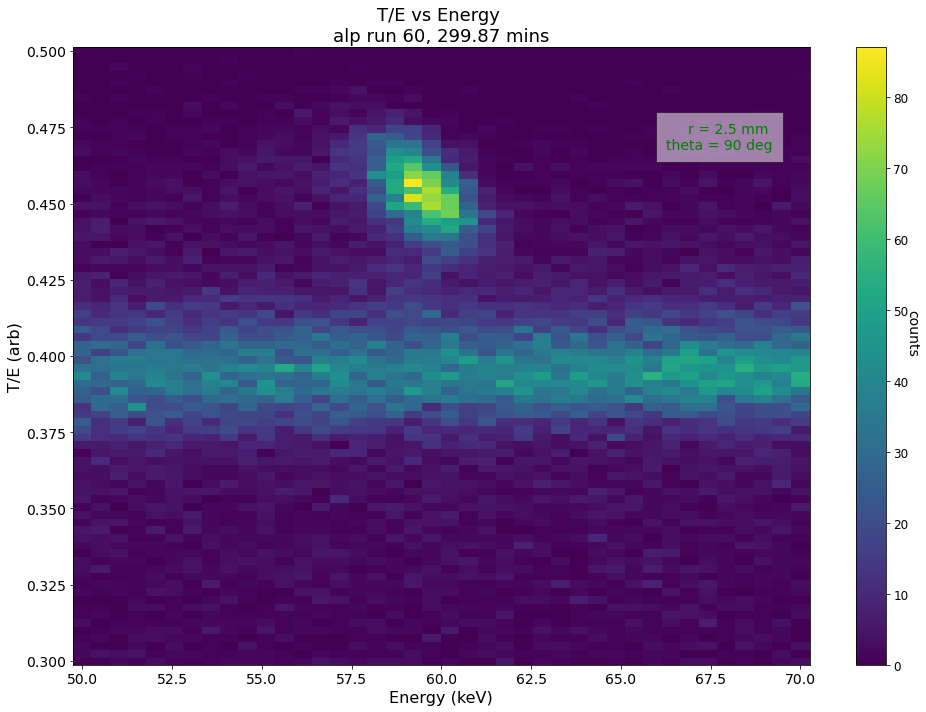

In [7]:
fig, ax = plt.subplots()
elo, ehi, epb = 50, 70, 0.5
ToElo, ToEhi, ToEpb= 0.3,  0.5, 0.0025

nbx = int((ehi-elo)/epb)
nby = int((ToEhi-ToElo)/ToEpb)



# fig.suptitle(f'T/E vs Energy', horizontalalignment='center', fontsize=16)

ToE_hist_norm, xedges, yedges = np.histogram2d(df['trapEftp_cal'], df['ToE'], bins=[nbx, nby], range=([elo, ehi], [ToElo, ToEhi]))
X, Y = np.mgrid[elo:ehi:nbx*1j, ToElo:ToEhi:nby*1j]


pcm = plt.pcolormesh(X, Y, ToE_hist_norm,  shading='nearest') #0.002, 0.2

cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel(f'Energy (keV)', fontsize=16)
ax.set_ylabel('T/E (arb)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)


ax.text(0.95, 0.83, f'r = {radius} mm \ntheta = {angle_det} deg', verticalalignment='bottom',
            horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# plt.legend()
plt.title(f'T/E vs Energy \n{runtype} run {run}, {rt_min:.2f} mins', fontsize=18)
plt.tight_layout()
# plt.ylim(-0.05, 0.1)
# plt.ylim(-0.05, 0.08)
# plt.ylim(0.42, 0.51)
# plt.xlim(52.5, 65)
plt.show()

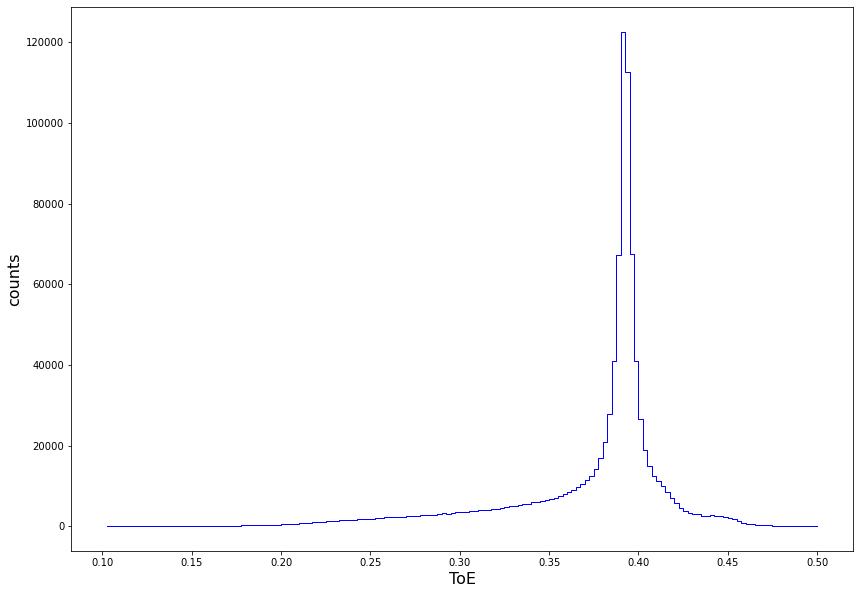

In [8]:
ToElo, ToEhi, ToEpb= 0.1,  0.5, 0.0025
nbx = int((ToEhi-ToElo)/ToEpb)

# bl_sig_lo, bl_sig_hi = 3.1, 5. # run 70
# bl_sig_lo, bl_sig_hi = 3.1, 5.25
# bl_sig_lo_raw, bl_sig_hi_raw = quant_raw_sig[0], quant_raw_sig[1]  

ToE_hist, bins = np.histogram(df['ToE'], bins=nbx,
                range=[ToElo, ToEhi])

plt.plot(bins[1:], ToE_hist, ds='steps', c='b', lw=1)


# plt.axvline(bl_sig_lo_raw, c='r', lw=1)
# plt.axvline(bl_sig_hi_raw, c='r', lw=1)

plt.xlabel('ToE', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.show()

80


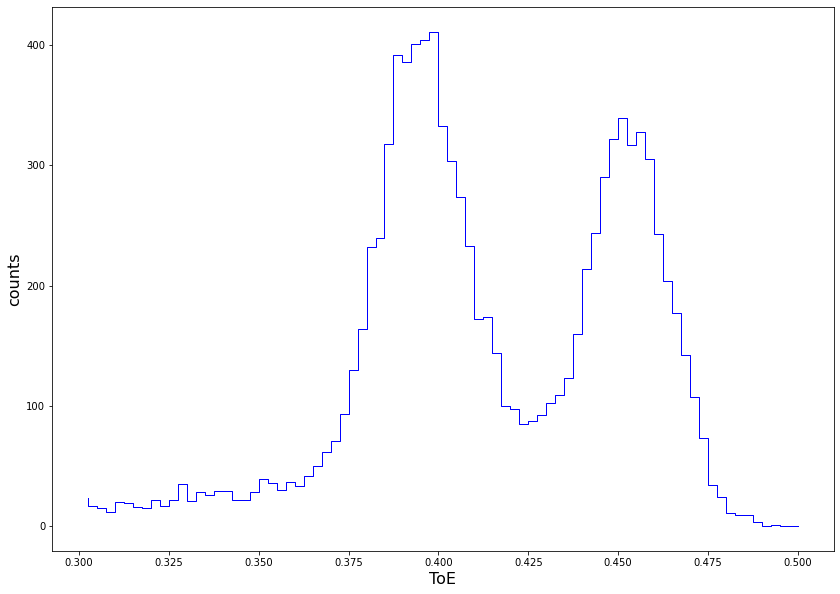

In [9]:
ToElo, ToEhi, ToEpb= 0.3,  0.5, 0.0025
nbx = int((ToEhi-ToElo)/ToEpb)

print(nbx)

# bl_sig_lo, bl_sig_hi = 3.1, 5. # run 70
# bl_sig_lo, bl_sig_hi = 3.1, 5.25
# bl_sig_lo_raw, bl_sig_hi_raw = quant_raw_sig[0], quant_raw_sig[1]  

ToE_hist, bins = np.histogram(df_60['ToE'], bins=nbx,
                range=[ToElo, ToEhi])

plt.plot(bins[1:], ToE_hist, ds='steps', c='b', lw=1)


# plt.axvline(bl_sig_lo_raw, c='r', lw=1)
# plt.axvline(bl_sig_hi_raw, c='r', lw=1)

plt.xlabel('ToE', fontsize=16)
plt.ylabel('counts', fontsize=16)

# plt.xlim(0.35, 0.5)
plt.show()

In [10]:
# First use gauss_mode_width_max to use for initial guesses in fit_hist

if run < 66:
    ToE_60_hist, bins, tvars = pgh.get_hist(df_60['ToE'], bins=50, range=[0.43, 0.5]) #range=[54, 65]
    # plt.plot(bins[1:], ToE_60_hist, ds='steps', c='b', lw=1)
    pars, cov = pgf.gauss_mode_width_max(ToE_60_hist, bins, tvars)
    mode = pars[0]
    width = pars[1]
    amp = pars[2]
    print(f'mode: {mode}')
    print(f'width: {width}')
    print(f'amp: {amp}')

mode: 0.4532734091575535
width: 0.01229330255981523
amp: 183.61184094844742


chi square: 1.8053967965932054
mean: 0.4522095206648024
width: 0.01176184555598587
amp: 5.5151595275064444
C: -0.04404200906397526


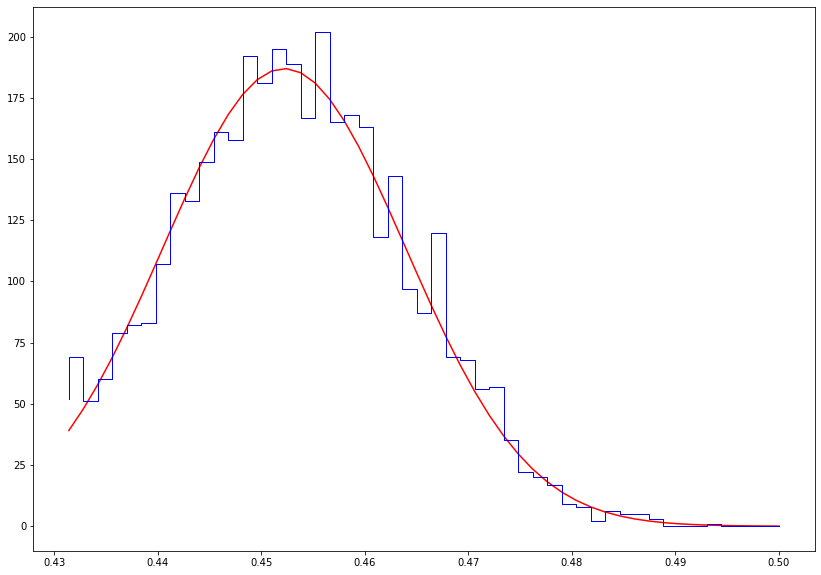

In [11]:
if run < 66: 
    Tpars, Tcov = pgf.fit_hist(cage_utils.gauss_fit_func, ToE_60_hist, bins, tvars, guess = (amp, mode, width, 1))

    chi_2_ToE_60 = pgf.goodness_of_fit(ToE_60_hist, bins, cage_utils.gauss_fit_func, Tpars)


    ToE_60_mean = Tpars[1]
    ToE_60_sig = Tpars[2]
    ToE_60_amp = Tpars[0]
    ToE_60_const = Tpars[3]


    print(f'chi square: {chi_2_ToE_60}')
    print(f'mean: {ToE_60_mean}')
    print(f'width: {ToE_60_sig}')
    print(f'amp: {ToE_60_amp}')
    print(f'C: {ToE_60_const}')
    
    plt.plot(bins[1:], cage_utils.gauss_fit_func(bins[1:], *Tpars), c = 'r')
    plt.plot(bins[1:], ToE_60_hist, ds='steps', c='b', lw=1)

In [12]:
# First use gauss_mode_width_max to use for initial guesses in fit_hist

ToE_60_main, bins, tvars = pgh.get_hist(df_60['ToE'], bins=100, range=[0.37, 0.42]) #range=[0.35, 0.42] for run < 66
# plt.plot(bins[1:], ToE_60_main, ds='steps', c='b', lw=1)
pars, cov = pgf.gauss_mode_width_max(ToE_60_main, bins, tvars)
mode = pars[0]
width = pars[1]
amp = pars[2]
print(f'mode: {mode}')
print(f'width: {width}')
print(f'amp: {amp}')

mode: 0.3895769361725964
width: 0.001334014342424321
amp: 91.76394719615986


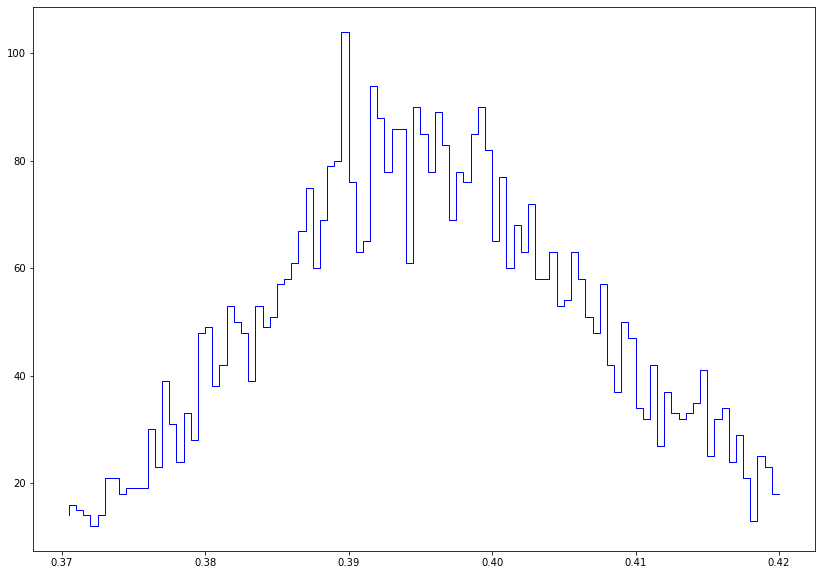

In [13]:
plt.plot(bins[1:], ToE_60_main, ds='steps', c='b', lw=1)

In [14]:
main_Tpars, main_Tcov = pgf.fit_hist(cage_utils.gauss_fit_func, ToE_60_main, bins, tvars, guess = (amp, mode, width, 1))

chi_2_ToE_main = pgf.goodness_of_fit(ToE_60_main, bins, cage_utils.gauss_fit_func, main_Tpars)

ToE_main_mean = main_Tpars[1]
ToE_main_sig = main_Tpars[2]
ToE_main_amp = main_Tpars[0]
ToE_main_const = main_Tpars[3]

# fwhm = width_fit*2.355

print(f'chi square: {chi_2_ToE_main}')
print(f'mean: {ToE_main_mean}')
print(f'width: {ToE_main_sig}')
print(f'amp: {ToE_main_amp}')
print(f'C: {ToE_main_const }')


chi square: 1.1880202692797415
mean: 0.3956792656262473
width: 0.011558750627279745
amp: 2.102400458606257
C: 7.931069430905195


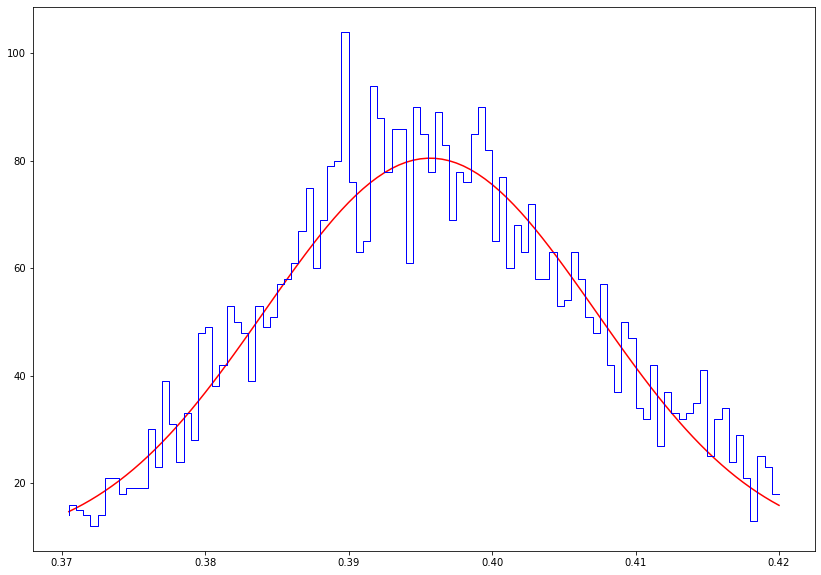

In [15]:
plt.plot(bins[1:], cage_utils.gauss_fit_func(bins[1:], *main_Tpars), c = 'r')
plt.plot(bins[1:], ToE_60_main, ds='steps', c='b', lw=1)

In [16]:
ToE_60_hi = 2*ToE_60_sig + ToE_60_mean
ToE_60_lo = ToE_60_mean - 2*ToE_60_sig 

ToE_bkg_hi = (2*ToE_main_sig + ToE_main_mean)
ToE_bkg_lo = (ToE_main_mean - 2*ToE_main_sig)

if ToE_60_lo < ToE_bkg_hi:
    ToE_60_lo = ToE_bkg_hi 

print(f'ToE background: {ToE_bkg_lo:.3f}, {ToE_bkg_hi:.3f}')
print(f'ToE 60 keV: {ToE_60_lo:.3f}, {ToE_60_hi:.3f}')

ToE background: 0.373, 0.419
ToE 60 keV: 0.429, 0.476


In [17]:
ToE_60 = f'({ToE_60_lo} <= ToE < {ToE_60_hi})'
ToE_left = f'({ToE_60_lo} <= ToE < {ToE_60_mean})'
ToE_right = f'({ToE_60_mean} <= ToE < {ToE_60_hi})'

ToE_bkg = f'({ToE_bkg_lo} < ToE < {ToE_bkg_hi})'

# ToE_bkg_left = f'({ToE_bkg_lo}<= ToE <{ToE_main_mean})'
# ToE_bkg_right = f'({ToE_main_mean}<= ToE <{ToE_bkg_hi})'

bkg_left = f'({ToE_bkg} and {bkg_60_left})' 
bkg_right = f'({ToE_bkg} and {bkg_60_right})' 
bkg = f'{bkg_left} or {bkg_right}'

ToE_60_3sigma = f'{cut_60_3sig} and {ToE_60}'

ToE_60_left = f'{cut_60_left} and {ToE_right}'
ToE_60_right = f'{cut_60_right} and {ToE_left}'


# print(ToE_left)
# print(ToE_60_left)
# print(ToE_60_right)

print(ToE_60_3sigma)
print(bkg)

# print(bkg_left)
# print(bkg_right)
# print(bkg)

(56.79438919282286 <= trapEftp_cal <= 62.1488692070768) and (0.4286858295528307 <= ToE < 0.47573321177677413)
((0.3725617643716878 < ToE < 0.41879676688080675) and (53.224735849986914 <= trapEftp_cal < 55.901975857113875)) or ((0.3725617643716878 < ToE < 0.41879676688080675) and (63.04128254278579 < trapEftp_cal <= 65.71852254991275))


In [18]:
times, all_60_raw = cage_utils.get_superpulse_taligned(df, dg, ToE_60_3sigma, all=True, norm=False)

using all 3854 Waveforms passing cut


In [19]:
times, bkg_60_raw = cage_utils.get_superpulse_taligned(df, dg, bkg, all=True, norm=False)

using all 4756 Waveforms passing cut


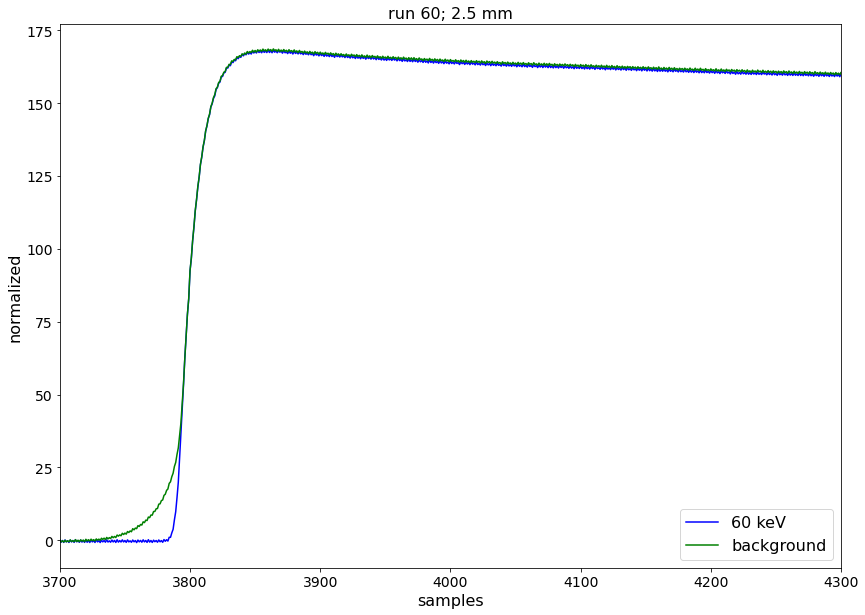

In [20]:
fig, ax = plt.subplots()
plt.plot(times[:-1], all_60_raw[:-1], '-b', label=('60 keV'))
plt.plot(times[:-1], bkg_60_raw[:-1], '-g', label=('background'))


# plt.xlim(0, 4300)
# plt.ylim(-0.025, 0.1)

plt.xlim(3700, 4300)
# plt.ylim(-0.025, 0.2)

# plt.xlim(3700, 3710)
# plt.ylim(-0.025, 0.1)


# plt.xlim(3800, 8000)
# plt.ylim(0.75, 1)

# plt.xlim(3800, 4300)
# plt.ylim(0.95, 1)

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('normalized', fontsize=16)

plt.legend(fontsize=16)

plt.title(f'run {run}; {radius} mm', fontsize = 16)
plt.show()

In [21]:
#pre_bkg_60_notched = notchFilter(bkg_60, f_notch=25e6, Q=20)
bkg_60_notched = cage_utils.notchFilter_SIS3302(bkg_60_raw, Q=20)

#pre_all_60_notched = notchFilter(all_60, f_notch=25e6, Q=20)
all_60_notched = cage_utils.notchFilter_SIS3302(all_60_raw, Q=20)

bkg_60 = np.divide(bkg_60_notched, np.amax(bkg_60_notched))
all_60 = np.divide(all_60_notched, np.amax(all_60_notched))

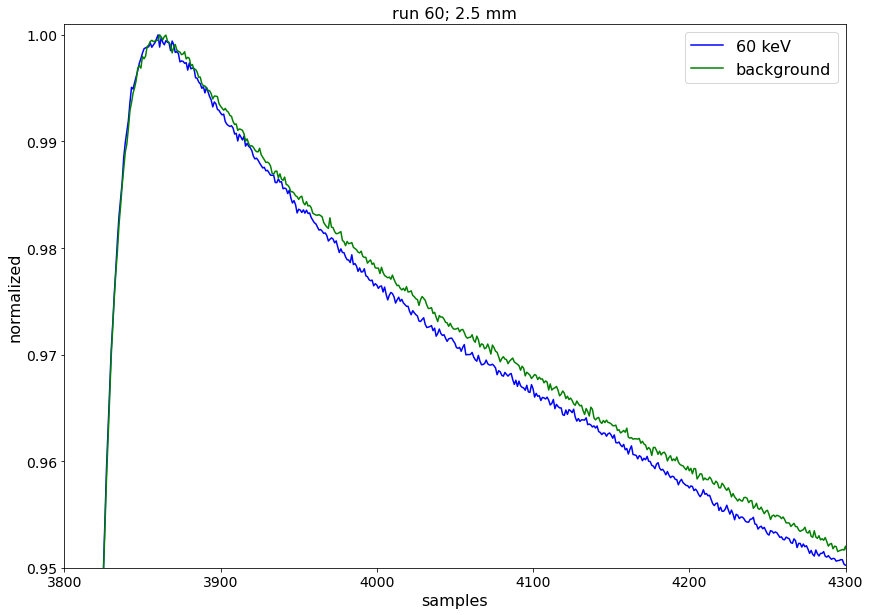

In [22]:
fig, ax = plt.subplots()
plt.plot(times[:-1], all_60[:-1], '-b', label=('60 keV'))
plt.plot(times[:-1], bkg_60[:-1], '-g', label=('background'))


# plt.xlim(0, 4300)
# plt.ylim(-0.025, 0.1)

# plt.xlim(3700, 4300)
# plt.ylim(-0.025, 0.2)

# plt.xlim(3700, 3710)
# plt.ylim(-0.025, 0.1)


# plt.xlim(3800, 8000)
# plt.ylim(0.75, 1)

plt.xlim(3800, 4300)
plt.ylim(0.95, 1.001)

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('normalized', fontsize=16)

plt.legend(fontsize=16)

plt.title(f'run {run}; {radius} mm', fontsize = 16)
plt.show()

In [23]:
nwfs_60 = len(df.query(ToE_60_3sigma).copy())
nwfs_bkg = len(df.query(bkg).copy())

print(nwfs_60, nwfs_bkg)

3854 4756


In [24]:
#Cuts to write:
# write_params = True
write_params = False

param_keys = ['ToE_60', 'ToE_bkg', 'bkg', 'ToE_60_3sigma']
param_list = [ToE_60, ToE_bkg, bkg, ToE_60_3sigma]


if write_params == True:
    for key, cut in zip(param_keys, param_list):
        cage_utils.writeJson('./analysis_60keV.json', run, key, cut)


In [25]:

all_60_pz = cage_utils.double_pole_zero([all_60_notched], 21250, 433, 0.045)[0]

Etrap_all_60 = cage_utils.trap_norm(all_60_pz, 100, 400)
trap0_all_60 = cage_utils.asymTrapFilter(all_60_pz, 100, 1, 400)
max_trap0_all_60 = np.argmax(trap0_all_60)

t0_all_60 = cage_utils.time_point_thresh_max(trap0_all_60, 0.0, max_trap0_all_60, 
                                            max_trap0_all_60 - 200)

Eftp_all_60 = Etrap_all_60[t0_all_60 + 400]

all_60_pz_norm = np.divide(all_60_pz, Eftp_all_60)

# print(np.amax(all_60_pz_norm))

pole-zero correcting 1 waveforms


In [26]:
# waveform_dict = {'run': , 'times':np.array(times), 'pure_60_wf': np.array(all_60), 'bkg_60': np.array(bkg_60), 'left_60': np.array(left_60), 'right_60': np.array(right_60)}
# bkg_and_60 = np.zeros(len(all_60))

wf_dict = {'run': run, 'nwfs_bkg': nwfs_bkg, 'nwfs_60': nwfs_60, 'samples': [times], 'bkg': [bkg_60], 'pure_60': [all_60], 
          'bkg_raw': [bkg_60_raw], 'pure_60_raw': [all_60_raw], 'pure_60_pz': [all_60_pz_norm]}
wf_df = pd.DataFrame(data=wf_dict)
print(wf_df)

   run  nwfs_bkg  nwfs_60                                            samples  \
0   60      4756     3854  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                                 bkg  \
0  [0.0012641805105388642, -0.0018463085880810564...   

                                             pure_60  \
0  [0.0009205507275075827, -0.0014419967061174864...   

                                             bkg_raw  \
0  [0.2798721614802267, -0.3494381833473595, 0.02...   

                                         pure_60_raw  \
0  [0.22586485284306404, -0.29567121358143, 0.084...   

                                          pure_60_pz  
0  [0.0009574101947184737, -0.0013891186210634513...  


In [27]:
save_superpulse = False

if save_superpulse ==True:
    outfile = f'./data/normScan/run{run}_superpulses.hdf5'
    wf_df.to_hdf(outfile, key='superpulses', mode='w')

In [65]:
# f_superpulse = './data/normScan/superpulses_60keV_allRuns.hdf5'
f_superpulse = './data/normScan/superpulses_1sig_60keV_allRuns.hdf5'
data_superpulse = pd.read_hdf(f_superpulse, key = '/superpulses')

data_superpulse = data_superpulse.query(f'run=={run}').copy()
    
bkg_sub_wf = np.array(data_superpulse['pure_60_pz'][0])

In [45]:
print(bkg_sub_wf)

[ 9.44851649e-04 -1.01373410e-03  4.20189016e-04 ...  9.98050934e-01
  1.00031111e+00  9.96946830e-01]


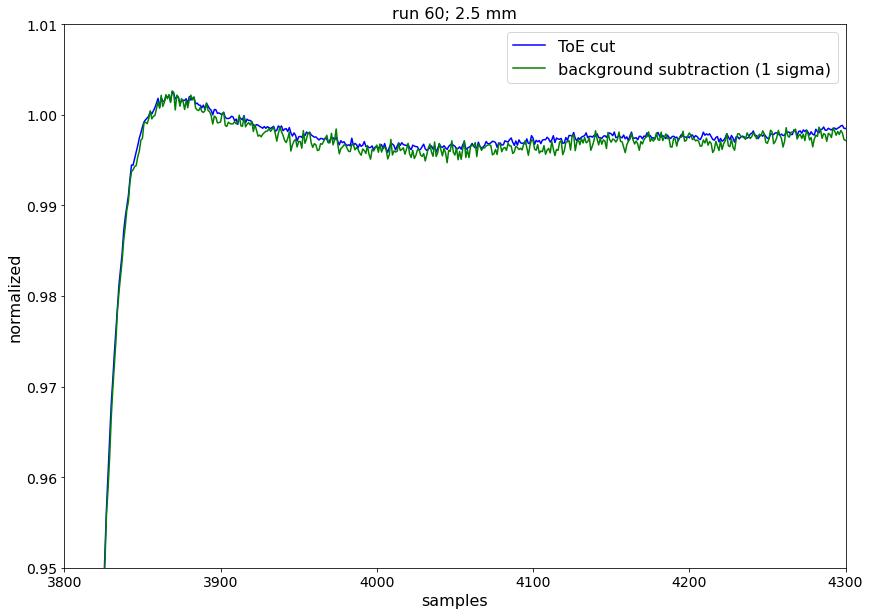

In [71]:
fig, ax = plt.subplots()
plt.plot(times, all_60_pz_norm, '-b', label=('ToE cut'))
plt.plot(times, bkg_sub_wf, '-g', label=('background subtraction (1 sigma)'))


# plt.xlim(0, 4300)
# plt.ylim(-0.025, 0.1)

# plt.xlim(3700, 3900)
# plt.ylim(-0.025, 0.2)

# plt.xlim(3750, 3875)
# plt.ylim(-0.025, 1.01)

# plt.xlim(3800, 4300)
# plt.ylim(0.95, 1.01)

# plt.xlim(3800, 8000)
# plt.ylim(0.75, 1.01)



plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('normalized', fontsize=16)

plt.legend(fontsize=16)

plt.title(f'run {run}; {radius} mm', fontsize = 16)
# plt.savefig(f'./plots/new_normScan/60keV_analysis/1sig/waveforms/run{run}_wf_bkg_sub.png', dpi=200)
plt.show()

In [72]:
diff = bkg_sub_wf - all_60_pz_norm

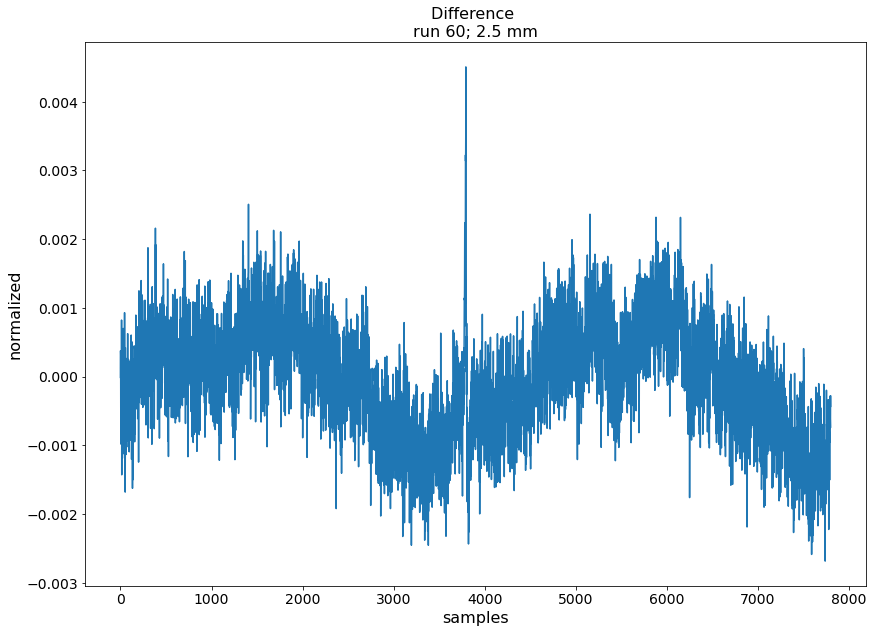

In [73]:
fig, ax = plt.subplots()
plt.plot(diff)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('normalized', fontsize=16)

# plt.legend(fontsize=16)

plt.title(f'Difference \nrun {run}; {radius} mm', fontsize = 16)
plt.savefig(f'./plots/new_normScan/60keV_analysis/1sig/waveforms/run{run}_wf_bkg_sub_diff.png', dpi=200)

In [44]:
times, left_60 = cage_utils.get_superpulse_taligned(df, dg, ToE_60_left, all=True, norm=False)

using all 1266 Waveforms passing cut


In [45]:
times, right_60 = cage_utils.get_superpulse_taligned(df, dg, ToE_60_right, all=True, norm=False)

using all 1216 Waveforms passing cut


In [46]:
#pre_bkg_60_notched = notchFilter(bkg_60, f_notch=25e6, Q=20)
left_60_notched = cage_utils.notchFilter_SIS3302(left_60, Q=20)

#pre_all_60_notched = notchFilter(all_60, f_notch=25e6, Q=20)
right_60_notched = cage_utils.notchFilter_SIS3302(right_60, Q=20)


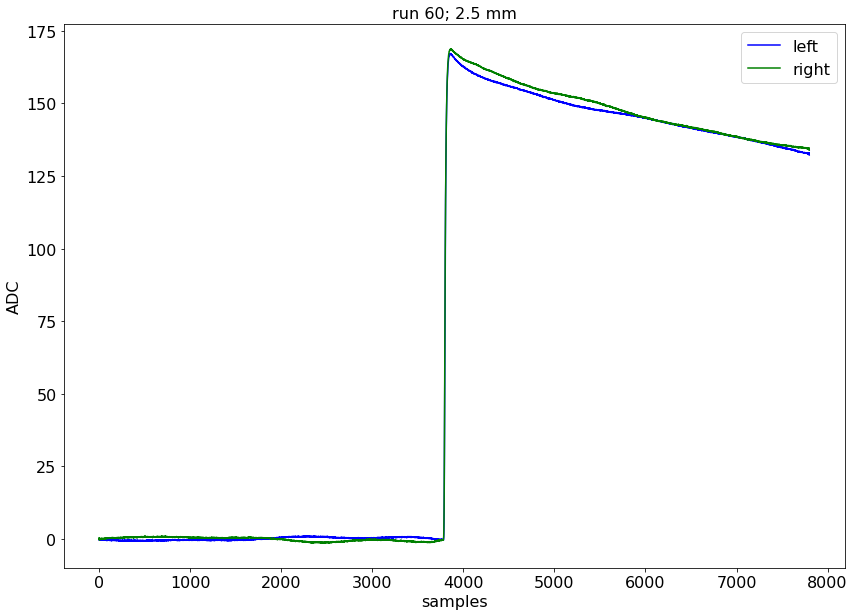

In [54]:
fig, ax = plt.subplots()
plt.plot(times, left_60_notched, '-b', label=('left'))
plt.plot(times, right_60_notched, '-g', label=('right'))
plt.legend()

# plt.xlim(3900, 4100)

# plt.xlim(0, 4300)
# plt.ylim(-2, 15)

# plt.xlim(3700, 8000)
# plt.ylim(120, 175)

plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('ADC', fontsize=16)

plt.legend(fontsize=16)

plt.title(f'run {run}; {radius} mm', fontsize = 16)

plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/run{run}_ToE_noiseComp.png', dpi=200)

plt.show()

In [ ]:
bl_mean_left = np.mean(left_60_notched[:3800])
bl_mean_right = np.mean(right_60_notched[:3800])

bl_sub_left = left_60_notched - bl_mean_left
bl_sub_right = right_60_notched - bl_mean_right

In [ ]:
fig, ax = plt.subplots()
plt.plot(times, bl_sub_left[:len(bl_sub_left)-1], '-b', label=('left'))
plt.plot(times, bl_sub_right[:len(bl_sub_right)-1], '-g', label=('right'))
plt.legend()

# plt.xlim(3900, 4100)

# plt.xlim(0, 4300)
# plt.ylim(-2, 15)

# plt.xlim(3800, 8000)
# plt.ylim(120, 175)

# plt.xlim(3900, 4200)
# plt.ylim(25, 140)

plt.xlim(3500, 6500)

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('ADC', fontsize=16)

plt.legend(fontsize=16)

plt.title(f'run {run}; {radius} mm', fontsize = 16)

plt.show()

In [ ]:
df_ToE_60_left = df.query(ToE_60_left).copy()
df_ToE_60_right = df.query(ToE_60_right).copy() 
df_ToE_60 = df.query(ToE_60_3sigma).copy()
# quant_raw = np.quantile(df_raw['bl'], q = (0.03, 0.98)) # 95%
counts_60 = len(df_ToE_60)
print(counts_60)

In [ ]:
fig, ax = plt.subplots()
elo, ehi, epb = 40, 80, 0.5
ToElo, ToEhi, ToEpb= 0.,  0.5, 0.0025

nbx = int((ehi-elo)/epb)
nby = int((ToEhi-ToElo)/ToEpb)



fig.suptitle(f'T/E vs Energy', horizontalalignment='center', fontsize=16)

ToE_hist_norm, xedges, yedges = np.histogram2d(df_ToE_60 ['trapEftp_cal'], df_ToE_60 ['ToE'], bins=[nbx, nby], range=([elo, ehi], [ToElo, ToEhi]))
X, Y = np.mgrid[elo:ehi:nbx*1j, ToElo:ToEhi:nby*1j]


pcm = plt.pcolormesh(X, Y, ToE_hist_norm, norm=LogNorm()) #0.002, 0.2

cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel(f'Energy (keV)', fontsize=16)
ax.set_ylabel('T/E (arb)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)


ax.text(0.95, 0.83, f'r = {radius} mm \ntheta = {angle_det} deg \nwf_triangle 100 ns, 10 ns', verticalalignment='bottom',
            horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# plt.legend()
plt.title(f'\n{runtype} run {run}, {rt_min:.2f} mins', fontsize=12)
plt.tight_layout()
# plt.ylim(-0.05, 0.1)
# plt.ylim(-0.05, 0.08)
plt.ylim(0.42, 0.51)
plt.xlim(52.5, 65)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = -10., 10., 0.05 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
ToElo, ToEhi, ToEpb= 0.,  0.5, 0.0025
ToE_bins  = int((ToEhi-ToElo)/ToEpb)
fig.suptitle(f'\nBaseline slope vs T/E', horizontalalignment='center', fontsize=16)
ToE_vs_bl, xedges, yedges = np.histogram2d(df_60['ToE'], df_60['bl_slope'], bins=[ToE_bins, bl_bins], range=([ToElo, ToEhi], [blo, bhi]))
X, Y = np.mgrid[ToElo:ToEhi:ToE_bins*1j, blo:bhi:bl_bins*1j]

pcm = plt.pcolormesh(X, Y, ToE_vs_bl, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('ToE', fontsize=16)
ax.set_ylabel('bl_slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = -10., 10., 0.05 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
ToElo, ToEhi, ToEpb= 0.,  0.5, 0.0025
ToE_bins  = int((ToEhi-ToElo)/ToEpb)
fig.suptitle(f'\nBaseline slope vs T/E', horizontalalignment='center', fontsize=16)
ToE_vs_bl, xedges, yedges = np.histogram2d(df_ToE_60_left['ToE'], df_ToE_60_left['bl_slope'], bins=[ToE_bins, bl_bins], range=([ToElo, ToEhi], [blo, bhi]))
X, Y = np.mgrid[ToElo:ToEhi:ToE_bins*1j, blo:bhi:bl_bins*1j]

pcm = plt.pcolormesh(X, Y, ToE_vs_bl, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('ToE', fontsize=16)
ax.set_ylabel('bl_slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = -10., 10., 0.05 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
ToElo, ToEhi, ToEpb= 0.,  0.5, 0.0025
ToE_bins  = int((ToEhi-ToElo)/ToEpb)
fig.suptitle(f'\nBaseline slope vs T/E', horizontalalignment='center', fontsize=16)
ToE_vs_bl, xedges, yedges = np.histogram2d(df_ToE_60_right['ToE'], df_ToE_60_right['bl_slope'], bins=[ToE_bins, bl_bins], range=([ToElo, ToEhi], [blo, bhi]))
X, Y = np.mgrid[ToElo:ToEhi:ToE_bins*1j, blo:bhi:bl_bins*1j]

pcm = plt.pcolormesh(X, Y, ToE_vs_bl, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('ToE', fontsize=16)
ax.set_ylabel('bl_slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = -10., 10., 0.05 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
tail_lo, tail_hi = -10e-5, -1e-5 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
tail_bins = 100
fig.suptitle(f'\nTail slope vs baseline slope', horizontalalignment='center', fontsize=16)
bl_vs_tail, xedges, yedges = np.histogram2d(df_60['bl_slope'], df_60['log_tail_fit_slope'], bins=[bl_bins, tail_bins], range=([blo, bhi], [tail_lo, tail_hi]))
X, Y = np.mgrid[blo:bhi:bl_bins*1j, tail_lo:tail_hi:tail_bins*1j]

pcm = plt.pcolormesh(X, Y, bl_vs_tail, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('bl_slope', fontsize=16)
ax.set_ylabel('tail slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = -10., 10., 0.05 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
# bl_bins = int((bhi-blo)/bpb)
bl_bins = 50
tail_lo, tail_hi = -10e-5, -1e-5 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
tail_bins = 50
fig.suptitle(f'\nTail slope vs baseline slope', horizontalalignment='center', fontsize=16)
bl_vs_tail, xedges, yedges = np.histogram2d(df_ToE_60_left['bl_slope'], df_ToE_60_left['log_tail_fit_slope'], bins=[bl_bins, tail_bins], range=([blo, bhi], [tail_lo, tail_hi]))
X, Y = np.mgrid[blo:bhi:bl_bins*1j, tail_lo:tail_hi:tail_bins*1j]

pcm = plt.pcolormesh(X, Y, bl_vs_tail, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('bl_slope', fontsize=16)
ax.set_ylabel('tail slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = -10., 10., 0.05 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
# bl_bins = int((bhi-blo)/bpb)
bl_bins = 50
tail_lo, tail_hi = -10e-5, -1e-5 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
tail_bins = 50
fig.suptitle(f'\nTail slope vs baseline slope', horizontalalignment='center', fontsize=16)
bl_vs_tail, xedges, yedges = np.histogram2d(df_ToE_60_right['bl_slope'], df_ToE_60_right['log_tail_fit_slope'], bins=[bl_bins, tail_bins], range=([blo, bhi], [tail_lo, tail_hi]))
X, Y = np.mgrid[blo:bhi:bl_bins*1j, tail_lo:tail_hi:tail_bins*1j]

pcm = plt.pcolormesh(X, Y, bl_vs_tail, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('bl_slope', fontsize=16)
ax.set_ylabel('tail slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = 9000, 9400, 10 #bl_slope
bl_bins = int((bhi-blo)/bpb)
elo, ehi, epb= 50, 80, 0.25
e_bins  = int((ehi-elo)/epb)
fig.suptitle(f'\ntail slope vs energy', horizontalalignment='center', fontsize=16)
energy_vs_tail, xedges, yedges = np.histogram2d(df['trapEftp_cal'], df['bl'], bins=[e_bins, bl_bins], range=([elo, ehi], [blo, bhi]))
X, Y = np.mgrid[elo:ehi:e_bins*1j, blo:bhi:bl_bins*1j]

pcm = plt.pcolormesh(X, Y, energy_vs_tail, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('energy', fontsize=16)
ax.set_ylabel('tail slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = 9000, 9400, 10 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
tail_lo, tail_hi = -10e-5, -1e-5 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
tail_bins = 100
fig.suptitle(f'\nTail slope vs baseline mean', horizontalalignment='center', fontsize=16)
bl_vs_tail, xedges, yedges = np.histogram2d(df_60['bl'], df_60['log_tail_fit_slope'], bins=[bl_bins, tail_bins], range=([blo, bhi], [tail_lo, tail_hi]))
X, Y = np.mgrid[blo:bhi:bl_bins*1j, tail_lo:tail_hi:tail_bins*1j]

pcm = plt.pcolormesh(X, Y, bl_vs_tail, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('bl', fontsize=16)
ax.set_ylabel('tail slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = 9000, 9400, 10 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
tail_lo, tail_hi = -10e-5, -1e-5 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
tail_bins = 100
fig.suptitle(f'\nTail slope vs baseline mean', horizontalalignment='center', fontsize=16)
bl_vs_tail, xedges, yedges = np.histogram2d(df_ToE_60_left['bl'], df_ToE_60_left['log_tail_fit_slope'], bins=[bl_bins, tail_bins], range=([blo, bhi], [tail_lo, tail_hi]))
X, Y = np.mgrid[blo:bhi:bl_bins*1j, tail_lo:tail_hi:tail_bins*1j]

pcm = plt.pcolormesh(X, Y, bl_vs_tail, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('bl', fontsize=16)
ax.set_ylabel('tail slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = 9000, 9400, 10 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
tail_lo, tail_hi = -10e-5, -1e-5 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
tail_bins = 100
fig.suptitle(f'\nTail slope vs baseline mean', horizontalalignment='center', fontsize=16)
bl_vs_tail, xedges, yedges = np.histogram2d(df_ToE_60_right['bl'], df_ToE_60_right['log_tail_fit_slope'], bins=[bl_bins, tail_bins], range=([blo, bhi], [tail_lo, tail_hi]))
X, Y = np.mgrid[blo:bhi:bl_bins*1j, tail_lo:tail_hi:tail_bins*1j]

pcm = plt.pcolormesh(X, Y, bl_vs_tail, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('bl', fontsize=16)
ax.set_ylabel('tail slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
tail_lo, tail_hi = -10e-5, -1e-5 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
tail_bins = 100
elo, ehi, epb= 50, 80, 0.25
e_bins  = int((ehi-elo)/epb)
fig.suptitle(f'\ntail slope vs energy', horizontalalignment='center', fontsize=16)
energy_vs_tail, xedges, yedges = np.histogram2d(df['trapEftp_cal'], df['log_tail_fit_slope'], bins=[e_bins, tail_bins], range=([elo, ehi], [tail_lo, tail_hi]))
X, Y = np.mgrid[elo:ehi:e_bins*1j, tail_lo:tail_hi:tail_bins*1j]

pcm = plt.pcolormesh(X, Y, energy_vs_tail, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('energy', fontsize=16)
ax.set_ylabel('tail slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = -10, 10., 0.5 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
elo, ehi, epb= 50, 80, 0.25
e_bins  = int((ehi-elo)/epb)
fig.suptitle(f'\nBaseline slope vs energy', horizontalalignment='center', fontsize=16)
energy_vs_bl, xedges, yedges = np.histogram2d(df['trapEftp_cal'], df['bl_slope'], bins=[e_bins, bl_bins], range=([elo, ehi], [blo, bhi]))
X, Y = np.mgrid[elo:ehi:e_bins*1j, blo:bhi:bl_bins*1j]

pcm = plt.pcolormesh(X, Y, energy_vs_bl, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('energy', fontsize=16)
ax.set_ylabel('bl_slope', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
np.amax(df_60['tp_0'])

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = 37000, 40000, 10 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
ToElo, ToEhi, ToEpb= 0.,  0.5, 0.0025
ToE_bins  = int((ToEhi-ToElo)/ToEpb)
fig.suptitle(f'\nt0 vs T/E', horizontalalignment='center', fontsize=16)
ToE_vs_bl, xedges, yedges = np.histogram2d(df_60['ToE'], df_60['tp_0'], bins=[ToE_bins, bl_bins], range=([ToElo, ToEhi], [blo, bhi]))
X, Y = np.mgrid[ToElo:ToEhi:ToE_bins*1j, blo:bhi:bl_bins*1j]

pcm = plt.pcolormesh(X, Y, ToE_vs_bl, norm=LogNorm())
# cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('ToE', fontsize=16)
ax.set_ylabel('t0', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = 38500, 40000, 20 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
elo, ehi, epb= 20, 100, 0.25
e_bins  = int((ehi-elo)/epb)
fig.suptitle(f'\nt0 vs energy', horizontalalignment='center', fontsize=16)
energy_vs_bl, xedges, yedges = np.histogram2d(df['trapEftp_cal'], df['tp_0'], bins=[e_bins, bl_bins], range=([elo, ehi], [blo, bhi]))
X, Y = np.mgrid[elo:ehi:e_bins*1j, blo:bhi:bl_bins*1j]

pcm = plt.pcolormesh(X, Y, energy_vs_bl, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('energy', fontsize=16)
ax.set_ylabel('t0', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = 38500, 40000, 20 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
elo, ehi, epb= 50, 5500, 10
e_bins  = int((ehi-elo)/epb)
fig.suptitle(f'\nt0 vs energy', horizontalalignment='center', fontsize=16)
energy_vs_bl, xedges, yedges = np.histogram2d(df['trapEftp_cal'], df['tp_0'], bins=[e_bins, bl_bins], range=([elo, ehi], [blo, bhi]))
X, Y = np.mgrid[elo:ehi:e_bins*1j, blo:bhi:bl_bins*1j]

pcm = plt.pcolormesh(X, Y, energy_vs_bl, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('energy', fontsize=16)
ax.set_ylabel('t0', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
df['tp0max'] = df['tp_max'] - df['tp_0']

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = 0, 5000, 60 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
elo, ehi, epb= 50, 80, 0.5
e_bins  = int((ehi-elo)/epb)
fig.suptitle(f'\ntp0max vs energy', horizontalalignment='center', fontsize=16)
energy_vs_bl, xedges, yedges = np.histogram2d(df['trapEftp_cal'], df['tp0max'], bins=[e_bins, bl_bins], range=([elo, ehi], [blo, bhi]))
X, Y = np.mgrid[elo:ehi:e_bins*1j, blo:bhi:bl_bins*1j]

pcm = plt.pcolormesh(X, Y, energy_vs_bl, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('energy', fontsize=16)
ax.set_ylabel('tp0max', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()

In [ ]:
fig, ax = plt.subplots()
blo, bhi, bpb = 0, 5000, 60 #bl_slope
# blo, bhi, bpb = 3., 6., 0.005 #bl_sig
bl_bins = int((bhi-blo)/bpb)
elo, ehi, epb= 50, 5500, 10
e_bins  = int((ehi-elo)/epb)
fig.suptitle(f'\ntp0max vs energy', horizontalalignment='center', fontsize=16)
energy_vs_bl, xedges, yedges = np.histogram2d(df['trapEftp_cal'], df['tp0max'], bins=[e_bins, bl_bins], range=([elo, ehi], [blo, bhi]))
X, Y = np.mgrid[elo:ehi:e_bins*1j, blo:bhi:bl_bins*1j]

pcm = plt.pcolormesh(X, Y, energy_vs_bl, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel('energy', fontsize=16)
ax.set_ylabel('tp0max', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14)
# plt.xlim(elo, ehi)
plt.show()